# Students Do: Predicting Gold Closing Prices

In this activity, you will gain hands-on experience by building an RNN LSTM for predicting gold closing prices using time-series data.

In [3]:
# Initial imports
import numpy as np
import pandas as pd

%matplotlib inline

## Instructions

### Initial Setup

To ensure models' reproducibility, set the random seed for `numpy` and `tensorflow` libraries.

In [4]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [5]:
from pathlib import Path
aapl_csv_path = Path('./aapl.csv')
aapl_df = pd.read_csv(aapl_csv_path, infer_datetime_format=True, index_col="date")
aapl_df.head()

,close,volume,open,high,low
date,,,,,
9/22/14,101.06,52421660,101.80,102.14,100.58
9/23/14,102.64,63255860,100.60,102.94,100.54
9/24/14,101.75,59974260,102.16,102.85,101.20
9/25/14,97.87,99689300,100.51,100.71,97.72
9/26/14,100.75,62276770,98.53,100.75,98.40


Use the `requests` library to retrieve the historical prices of gold in `json` format.

#### Data Cleaning

Before continue, corroborate if there are any `null` or missing values in the DataFrame, if so, fill the missing values with the previous price in the series.

**Note:** You may want to review the [Working with missing data guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) from the Pandas documentation.

In [6]:
# Looking for missing values
aapl_df.isnull().sum().sum()

0

In [7]:
# Filling missing values with the previous ones
aapl_df = aapl_df.fillna(method ='pad')

#### Create the Features `X` and Target `y` Data

Use the `window_data()` function bellow, to create the features set `X` and the target vector `y`. Define a window size of `30` days and use the column of the closing gold price (`USD (PM)`) for as feature and target column; this will allow your model to predict gold prices in USD.

In [8]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(aapl_df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[52421660 63255860 59974260 99689300 62276770 49263260 55119980 51400260
  47697150 43419580 36780620 42003200 57329820 77283330 66249770 53437060
  63287170 99942790 72017830 67723910 75705040 93786680 68140010 70760150
  46937880 34086120 47689070 52545580 40572000 44550790]
 [63255860 59974260 99689300 62276770 49263260 55119980 51400260 47697150
  43419580 36780620 42003200 57329820 77283330 66249770 53437060 63287170
  99942790 72017830 67723910 75705040 93786680 68140010 70760150 46937880
  34086120 47689070 52545580 40572000 44550790 52154490]
 [59974260 99689300 62276770 49263260 55119980 51400260 47697150 43419580
  36780620 42003200 57329820 77283330 66249770 53437060 63287170 99942790
  72017830 67723910 75705040 93786680 68140010 70760150 46937880 34086120
  47689070 52545580 40572000 44550790 52154490 41423660]] 

y sample values:
[[52154490]
 [41423660]
 [37365530]]


#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [10]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split - 1]
X_test = X[split:]

y_train = y[: split - 1]
y_test = y[split:]

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [11]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [12]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.27278426]
  [0.34476252]
  [0.32296083]
  [0.58681229]
  [0.33825782]
  [0.25180107]
  [0.29071086]
  [0.26599847]
  [0.24139643]
  [0.2129779 ]
  [0.16887121]
  [0.20356802]
  [0.30539219]
  [0.43795564]
  [0.36465291]
  [0.27953019]
  [0.34497053]
  [0.58849638]
  [0.40297368]
  [0.37444653]
  [0.42747009]
  [0.54759755]
  [0.37721094]
  [0.39461814]
  [0.23635214]
  [0.15096998]
  [0.24134275]
  [0.27360754]
  [0.19405968]
  [0.22049323]]

 [[0.34476252]
  [0.32296083]
  [0.58681229]
  [0.33825782]
  [0.25180107]
  [0.29071086]
  [0.26599847]
  [0.24139643]
  [0.2129779 ]
  [0.16887121]
  [0.20356802]
  [0.30539219]
  [0.43795564]
  [0.36465291]
  [0.27953019]
  [0.34497053]
  [0.58849638]
  [0.40297368]
  [0.37444653]
  [0.42747009]
  [0.54759755]
  [0.37721094]
  [0.39461814]
  [0.23635214]
  [0.15096998]
  [0.24134275]
  [0.27360754]
  [0.19405968]
  [0.22049323]
  [0.27100929]]

 [[0.32296083]
  [0.58681229]
  [0.33825782]
  [0.25180107]
  [0.29071086

---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [13]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure

Design the structure of your RNN LSTM as follows:

* Number of units per layer: `30` (same as the window size)

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to your model, remember to add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [14]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [15]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [16]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [17]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
10/10 [==============================] - 1s 71ms/step - loss: 0.0325
Epoch 2/10
10/10 [==============================] - 1s 69ms/step - loss: 0.0141
Epoch 3/10
10/10 [==============================] - 1s 60ms/step - loss: 0.0157
Epoch 4/10
10/10 [==============================] - 1s 65ms/step - loss: 0.0143
Epoch 5/10
10/10 [==============================] - 1s 70ms/step - loss: 0.0134
Epoch 6/10
10/10 [==============================] - 1s 61ms/step - loss: 0.0135
Epoch 7/10
10/10 [==============================] - 1s 83ms/step - loss: 0.0127
Epoch 8/10
10/10 [==============================] - 1s 68ms/step - loss: 0.0131
Epoch 9/10
10/10 [==============================] - 1s 71ms/step - loss: 0.0131
Epoch 10/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0129


---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [18]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.006847539450973272

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [19]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

Since you scaled the original values using the `MinMaxScaler`, you need to recover the original gold prices to better understand of the predictions. Use the `inverse_transform()` method of the scaler to decode the scaled testing and predicted values to their original scale.

In [20]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

#### Plotting Predicted Vs. Real Prices

Create a Pandas DataFrame with two columns as follows to plot the predicted vs. the actual gold prices.

* Column 1: Actual prices (testing data)

* Column 2: Predicted prices

Your DataFrame should look like the sample below:

![Sample actual vs. predicted gold prices](../Images/sample-gold-prices-predictions-df.png)

In [21]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
0,30237640.0,33681328.0
1,34581850.0,33956152.0
2,26750260.0,34188464.0
3,34949690.0,34306592.0
4,28976200.0,34372068.0


Use the `plot()` method from the DataFrame to create a line chart to contrast the actual vs. the predicted gold prices.

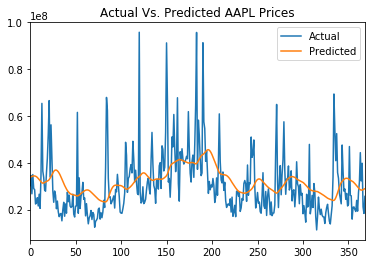

In [22]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted AAPL Prices")